In [14]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from utils import *

In [16]:
from xgboost import XGBRegressor
import shap

In [17]:
import pandas as pd
df=pd.read_csv("E:\Backup\Data\Processed&FeatureEngineered.csv")
print(df.columns)

leaky_cols = ['PROFITPER', 'PROFIT'] 
df = df.drop(columns=leaky_cols, errors='ignore')


Index(['Unnamed: 0', 'ITEMNAME', 'PATTERN', 'COLOR', 'SUPPCITY', 'MONTH',
       'NETSALESRATE', 'PROFITPER', 'SALESQTY', 'SALESAMOUNT',
       'UNIT_SALE_VALUE', 'PROFIT', 'IS_DISCOUNTED', 'ITEM_FREQ',
       'LOG_PROFIT'],
      dtype='object')


<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:2: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Admin\AppData\Local\Temp\ipykernel_19428\253606629.py:2: SyntaxWarning: invalid escape sequence '\B'
  df=pd.read_csv("E:\Backup\Data\Processed&FeatureEngineered.csv")


In [18]:
#Frequency Encoding for high-cardinality features
frequency_encoding = df['ITEMNAME'].value_counts()
df['ITEM_FREQ'] = df['ITEMNAME'].map(frequency_encoding)
df['PATTERN'] = df['PATTERN'].map(df['PATTERN'].value_counts())
df_clean= df.drop(columns=['ITEMNAME', 'PATTERN'])

x=df_clean.drop(['LOG_PROFIT'],axis=1)
y=df_clean['LOG_PROFIT']

x['UNIT_SALE_VALUE'] = x['UNIT_SALE_VALUE'].replace([np.inf, -np.inf], np.nan)
x['UNIT_SALE_VALUE']= x['UNIT_SALE_VALUE'].fillna(x['UNIT_SALE_VALUE'].mean(numeric_only=True))

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.4)

encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore') 
low_cardinality_cat_columns=['SUPPCITY', 'COLOR',  'IS_DISCOUNTED']
X_train_encoded = encoder.fit_transform(x_train[low_cardinality_cat_columns])  # Learn categories from training set
X_test_encoded = encoder.transform(x_test[low_cardinality_cat_columns]) 

# Separate numeric columns
numeric_cols = [col for col in x_train.columns if col not in low_cardinality_cat_columns]

# Get categorical feature names after encoding
cat_feature_names = encoder.get_feature_names_out(low_cardinality_cat_columns)

# Combine numeric + encoded categorical columns
X_train_encoded = np.hstack([x_train[numeric_cols].to_numpy(), X_train_encoded])
X_test_encoded= np.hstack([x_test[numeric_cols].to_numpy(), X_test_encoded])

# Combine feature names for all columns
encoded_feature_names = numeric_cols + cat_feature_names.tolist()



In [19]:

X_sample = X_train_encoded[:1000]
y_sample = y_train[:1000]

xgb = XGBRegressor(random_state=42)

# Parameter grid (single combination)
param_grid = {
    'learning_rate': [0.05],
    'max_depth': [7],
    'n_estimators': [200],
    'subsample': [0.8]
}

# GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,          # 3-fold cross-validation
    scoring='r2',  # Change to 'neg_mean_squared_error' if you want RMSE
    verbose=1,
    n_jobs=-1
)

# Fit
grid_xgb.fit(X_sample, y_sample)

# Best parameters & score
print("Best Params:", grid_xgb.best_params_)
print("Best Score:", grid_xgb.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 0.4215918910398944


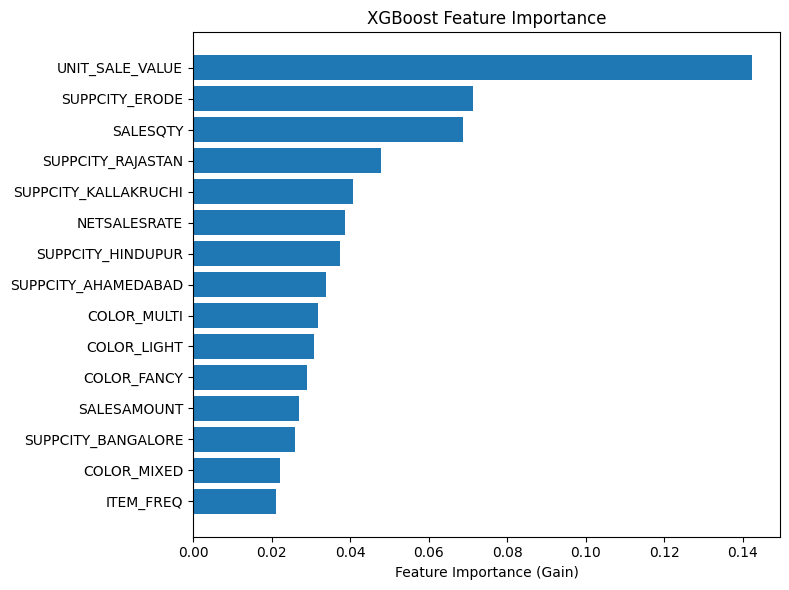

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_xgb = grid_xgb.best_estimator_
importances = best_xgb.feature_importances_

importance_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()



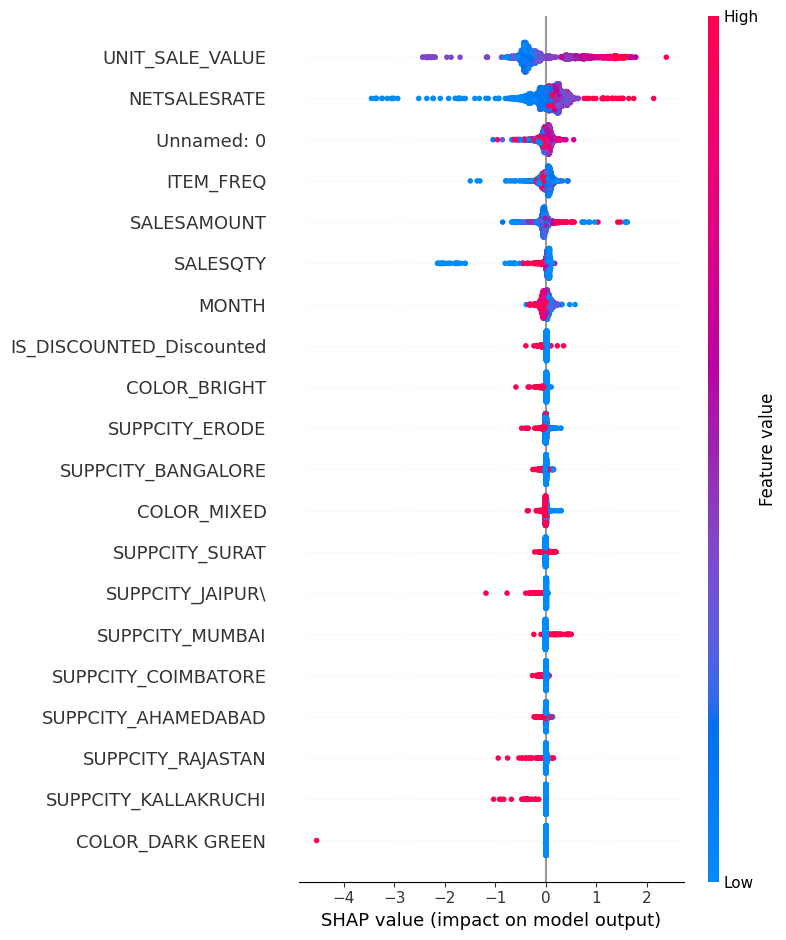

In [22]:


best_xgb = grid_xgb.best_estimator_

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_encoded)

shap.summary_plot(shap_values, X_test_encoded, feature_names=encoded_feature_names)


We used SHAP to analyze feature importance in our profit prediction model. Initially, the most influential feature appeared to be PROFITPER, which directly encodes the target variable (PROFIT) and leads to target leakage. This inflated the model's accuracy and misled feature importance.

After removing PROFITPER and other derived features, we retrained the model and re-analyzed using SHAP. The updated SHAP plot shows that:

UNIT_SALE_VALUE and NETSALESRATE are the most influential features.

MONTH, ITEM_FREQ, and SALESAMOUNT also contribute moderately.

High UNIT_SALE_VALUE values (red dots on right) generally increase predicted profit, suggesting that higher-priced items contribute more to profit.

From this, we infer that pricing strategy (unit price) and sales rate are key drivers of profitability.




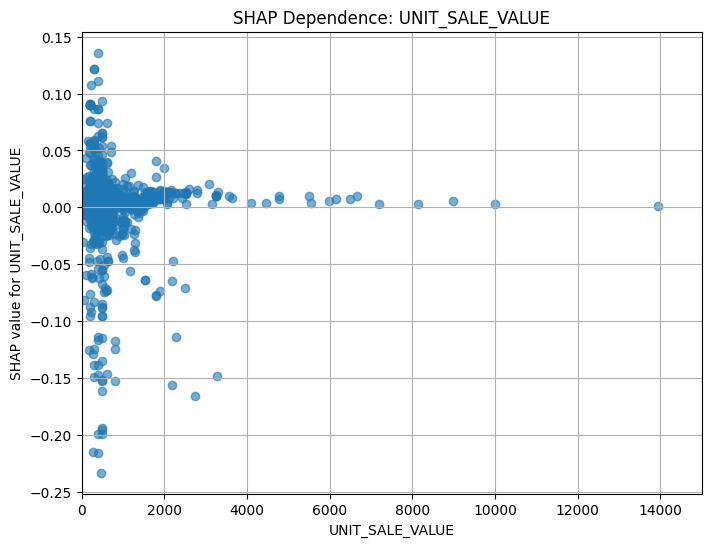

In [23]:
import matplotlib.pyplot as plt
# Ensure this feature exists in your data
feature = 'UNIT_SALE_VALUE'

feature_index = list(x_test.columns).index(feature)
shap_vals_feature = shap_values[:, feature_index]

plt.figure(figsize=(8, 6))
plt.scatter(x_test[feature], shap_vals_feature, alpha=0.6)

plt.xlabel(feature)
plt.ylabel(f"SHAP value for {feature}")
plt.title(f"SHAP Dependence: {feature}")
plt.xlim(0, 15000)  # <- Set x-axis limit as needed
plt.grid(True)
plt.show()


UNIT_SALE_VALUE strongly influences profit predictions at lower values, often negatively — meaning cheaper items tend to lower predicted profit. The effect quickly diminishes for higher-priced items, suggesting that once items are expensive enough, their price alone doesn’t add much predictive power.